In [1]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, unix_timestamp, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear, to_date
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as sklearn_min_max_scaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler,  StringIndexer
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [4]:
spark = SparkSession.builder.config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").appName("predictc").getOrCreate()


your 131072x1 screen size is bogus. expect trouble
24/12/11 13:35:56 WARN Utils: Your hostname, LAPTOP-DN3PCHGN resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/11 13:35:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/11 13:35:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/11 13:35:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
# Đọc dữ liệu từ file parquet
parquet_path = "/home/hoan123/project-master/delta_lake/delta_lake_table_3/"
df = spark.read.parquet(parquet_path)

In [6]:
# Sắp xếp dữ liệu theo cột datetime
df_sorted = df.orderBy("datetime")


In [7]:
condition_to_index = {
    "Cloudy": 0,
    "Light rain": 1,
    "Patchy rain possible": 2,
    "Moderate or heavy rain shower": 3,
    "Patchy light rain": 4,
    "Clear": 5,
    "Partly cloudy": 6,
    "Sunny": 7,
    "Patchy light drizzle": 8,
    "Light drizzle": 9,
    "Patchy light rain with thunder": 10,
    "Mist": 11,
    "Moderate rain at times": 12,
    "Thundery outbreaks possible": 13,
    "Moderate or heavy rain with thunder": 14,
    "Overcast": 15,
    "Moderate rain": 16,
    "Light rain shower": 17,
    "Heavy rain": 18,
    "Heavy rain at times": 19,
    "Fog": 20
}

# Bước 2: Hàm chuyển đổi chuỗi sang chỉ số
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def map_condition(condition):
    return condition_to_index.get(condition, -1)  # Trả về -1 nếu không tìm thấy giá trị phù hợp

map_condition_udf = udf(map_condition, IntegerType())

# Bước 3: Áp dụng UDF để tạo các cột condition đã mã hóa
df_sorted = df_sorted.withColumn("condition_index", map_condition_udf("condition"))

# Hiển thị kết quả
df_sorted.show()


+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+---------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|condition_index|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+---------------+
|2024-01-01 00:00:00|Hanoi|Vietnam| 21.0333|   105.85|  20.7|     5.8|    82.0|      0.0|       Partly cloudy|              6|
|2024-01-01 01:00:00|Hanoi|Vietnam| 21.0333|   105.85|  20.4|     6.0|    84.0|      0.0|              Cloudy|              0|
|2024-01-01 02:00:00|Hanoi|Vietnam| 21.0333|   105.85|  20.0|     4.9|    85.0|      0.0|              Cloudy|              0|
|2024-01-01 03:00:00|Hanoi|Vietnam| 21.0333|   105.85|  19.8|     4.5|    86.0|      0.0|            Overcast|             15|
|2024-01-01 04:00:00|Hanoi|Vietnam| 21.0333|   105.85|  19.6|     4.7|    87.0|      0.0|            Overcast| 

In [8]:

window = Window.orderBy("datetime")

# Thêm các cột feature từ các bước thời gian trước
df_with_lags = (
    df_sorted
    .withColumn("temp_c_t-1", lag("temp_c", 1).over(window))
    .withColumn("temp_c_t-2", lag("temp_c", 2).over(window))
    .withColumn("temp_c_t-3", lag("temp_c", 3).over(window))
    .withColumn("temp_c_t-4", lag("temp_c", 4).over(window))
    .withColumn("humidity_t-1", lag("humidity", 1).over(window))
    .withColumn("humidity_t-2", lag("humidity", 2).over(window))
    .withColumn("humidity_t-3", lag("humidity", 3).over(window))
    .withColumn("humidity_t-4", lag("humidity", 4).over (window))
    .withColumn("wind_mph_t-1", lag("wind_mph", 1).over(window))
    .withColumn("wind_mph_t-2", lag("wind_mph", 2).over(window))
    .withColumn("wind_mph_t-3", lag("wind_mph", 3).over(window))
    .withColumn("wind_mph_t-4", lag("wind_mph", 4).over(window))
    .withColumn("precip_mm_t-1", lag("precip_mm", 1).over(window))
    .withColumn("precip_mm_t-2", lag("precip_mm", 2).over(window))
    .withColumn("precip_mm_t-3", lag("precip_mm", 3).over(window))
    .withColumn("precip_mm_t-4", lag("precip_mm", 4).over(window))
    .withColumn("condition_t-1", lag("condition_index", 1).over(window))
    .withColumn("condition_t-2", lag("condition_index", 2).over(window))
    .withColumn("condition_t-3", lag("condition_index", 3).over(window))
    .withColumn("condition_t-4", lag("condition_index", 4).over(window))
    .withColumn("hour", hour("datetime"))
    .withColumn("day_of_month", dayofmonth("datetime"))
    .withColumn("day_of_week", dayofweek("datetime"))
    .withColumn("month", month("datetime"))
    .withColumn("quarter", quarter("datetime"))
    .withColumn("week", weekofyear("datetime"))
)

# Chọn các cột cần thiết và đổi tên cột label
df_final = df_with_lags.select(
    "datetime", 
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "humidity_t-1", "humidity_t-2", "humidity_t-3", "humidity_t-4",
    "wind_mph_t-1", "wind_mph_t-2","wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",  
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week", 
    "condition_index"  # Nhiệt độ hiện tại làm nhãn
).withColumnRenamed("condition_index", "label")

# Bỏ các hàng không đủ dữ liệu
df_final = df_final.na.drop()
df_final.show()


24/12/11 13:36:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/11 13:36:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance

+-------------------+----------+----------+----------+----------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----+------------+-----------+-----+-------+----+-----+
|           datetime|temp_c_t-1|temp_c_t-2|temp_c_t-3|temp_c_t-4|humidity_t-1|humidity_t-2|humidity_t-3|humidity_t-4|wind_mph_t-1|wind_mph_t-2|wind_mph_t-3|wind_mph_t-4|precip_mm_t-1|precip_mm_t-2|precip_mm_t-3|precip_mm_t-4|condition_t-1|condition_t-2|condition_t-3|condition_t-4|hour|day_of_month|day_of_week|month|quarter|week|label|
+-------------------+----------+----------+----------+----------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----+------------+-----------+-----+-------+-

In [9]:


# Thêm cột 'date' để lọc train-test
df_final = df_final.withColumn("date", to_date("datetime"))

# Chia dữ liệu train-test
train_data = df_final.filter(col("date") < "2024-10-30").drop("date")
test_data = df_final.filter(col("date") >= "2024-10-30").drop("date")

# Tạo feature vector
feature_cols = [
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "humidity_t-1", "humidity_t-2",  "humidity_t-3", "humidity_t-4",
    "wind_mph_t-1", "wind_mph_t-2", "wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data).select("features", "label", "datetime")
test_data = assembler.transform(test_data).select("features", "label", "datetime")


In [10]:
train_data.printSchema()


root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- datetime: timestamp (nullable = true)



In [11]:
from pyspark.sql.functions import col
train_data = train_data.withColumn("label", col("label").cast("double"))
test_data = test_data.withColumn("label", col("label").cast("double"))


In [12]:
from pyspark.sql.functions import col
train_data = train_data.na.drop()
test_data = test_data.na.drop()


In [13]:
train_data.select("features").show(1, truncate=False)


24/12/11 13:36:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 1

+------------------------------------------------------------------------------------------------------------------+
|features                                                                                                          |
+------------------------------------------------------------------------------------------------------------------+
|[19.8,20.0,20.4,20.7,86.0,85.0,84.0,82.0,4.5,4.9,6.0,5.8,0.0,0.0,0.0,0.0,15.0,0.0,0.0,6.0,4.0,1.0,2.0,1.0,1.0,1.0]|
+------------------------------------------------------------------------------------------------------------------+
only showing top 1 row



In [14]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# === Random Forest ===
# Khởi tạo mô hình Random Forest với tham số cố định
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=70, maxDepth=10)

# Huấn luyện mô hình Random Forest
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# === Logistic Regression ===
# Khởi tạo mô hình Logistic Regression với tham số cố định
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=50, regParam=0.1)

# Huấn luyện mô hình Logistic Regression
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# === Đánh giá hiệu năng ===
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Đánh giá Random Forest
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

# Đánh giá Logistic Regression
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# === Feature Importance (Random Forest) ===
rf_feature_importances = rf_model.featureImportances
print("Random Forest Feature Importances:")
for idx, importance in enumerate(rf_feature_importances):
    print(f"Feature {idx}: {importance:.4f}")

# Logistic Regression không cung cấp feature importance, nhưng có thể sử dụng weights
# lr_coefficients = lr_model.coefficients
# print("Logistic Regression Coefficients:")
# for idx, coefficient in enumerate(lr_coefficients):
#     print(f"Feature {idx}: {coefficient:.4f}")

# === Lưu mô hình (tuỳ chọn) ===



24/12/11 13:36:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:36:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 1

Random Forest Accuracy: 0.6944444444444444


24/12/11 13:37:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:37:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:37:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:37:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Logistic Regression Accuracy: 0.375
Random Forest Feature Importances:
Feature 0: 0.0437
Feature 1: 0.0318
Feature 2: 0.0267
Feature 3: 0.0319
Feature 4: 0.0465
Feature 5: 0.0260
Feature 6: 0.0261
Feature 7: 0.0256
Feature 8: 0.0201
Feature 9: 0.0205
Feature 10: 0.0205
Feature 11: 0.0216
Feature 12: 0.1391
Feature 13: 0.0433
Feature 14: 0.0283
Feature 15: 0.0245
Feature 16: 0.1776
Feature 17: 0.0661
Feature 18: 0.0263
Feature 19: 0.0172
Feature 20: 0.0447
Feature 21: 0.0235
Feature 22: 0.0129
Feature 23: 0.0175
Feature 24: 0.0087
Feature 25: 0.0294


24/12/11 13:38:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:38:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:38:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:38:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:38:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:38:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 1

Confusion Matrix for Random Forest:
[[  6   0   6   2  27   0   0   0   5   0]
 [  0   0   2   0   0   0   0   1   0   0]
 [  0   0  29   0   8   0   0   0   3   3]
 [  0   0   0  94  12   5   0   0   0   0]
 [  1   0   6  12 123  11   0   0   4   0]
 [  0   0   0   5  13  73   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   3   0   0]
 [  2   0   7   0  10   1   0   0   9   0]
 [  0   0   3   0   1   0   0   1   0  13]]


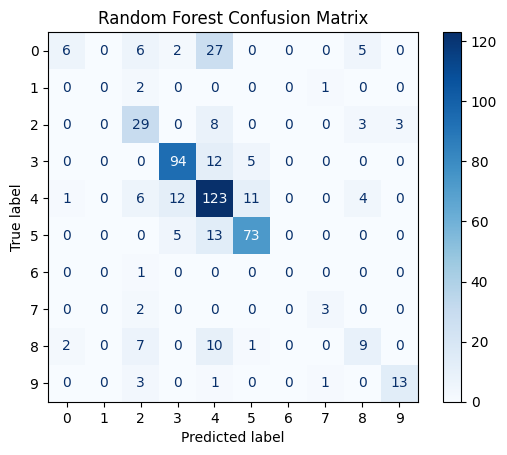

Confusion Matrix for Logistic Regression:
[[ 0  0  7  0 34  4  0  0  0  1]
 [ 0  0  2  0  1  0  0  0  0  0]
 [ 0  0 18  0 22  0  0  0  0  3]
 [ 0  0  4  6 69 32  0  0  0  0]
 [ 0  0 19  0 99 39  0  0  0  0]
 [ 0  0  2  0 35 54  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0]
 [ 0  0  4  0  1  0  0  0  0  0]
 [ 0  0  9  0 19  1  0  0  0  0]
 [ 0  0  3  0  3  0  0  0  0 12]]


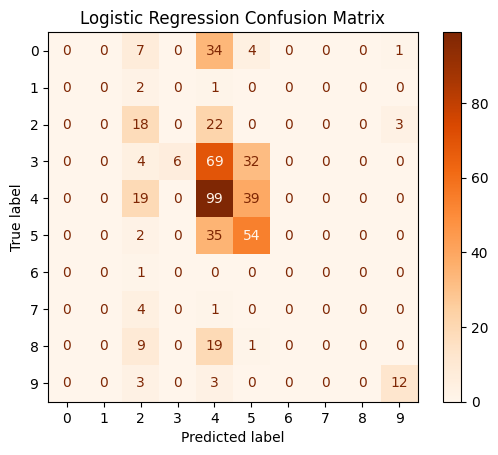

In [18]:
from pyspark.sql.functions import col
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Chuyển đổi dự đoán thành DataFrame Pandas
rf_predictions_pd = rf_predictions.select("label", "prediction").toPandas()
lr_predictions_pd = lr_predictions.select("label", "prediction").toPandas()

# Tính toán confusion matrix cho Random Forest
rf_conf_matrix = confusion_matrix(rf_predictions_pd['label'], rf_predictions_pd['prediction'])

# Hiển thị confusion matrix của Random Forest
print("Confusion Matrix for Random Forest:")
print(rf_conf_matrix)
ConfusionMatrixDisplay(confusion_matrix=rf_conf_matrix).plot(cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

# Tính toán confusion matrix cho Logistic Regression
lr_conf_matrix = confusion_matrix(lr_predictions_pd['label'], lr_predictions_pd['prediction'])

# Hiển thị confusion matrix của Logistic Regression
print("Confusion Matrix for Logistic Regression:")
print(lr_conf_matrix)
ConfusionMatrixDisplay(confusion_matrix=lr_conf_matrix).plot(cmap="Oranges")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [23]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# === Naive Bayes ===
# Khởi tạo mô hình Naive Bayes với tham số cố định
nb = NaiveBayes(labelCol="label", featuresCol="features", modelType="multinomial")

# Huấn luyện mô hình Naive Bayes
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

# === Đánh giá hiệu năng ===
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Đánh giá Naive Bayes
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy}")

# Naive Bayes không có feature importance như Random Forest hoặc Logistic Regression
# => Nếu cần, có thể phân tích các thông số của mô hình Naive Bayes như: pi, theta


24/12/11 13:52:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:52:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:52:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:52:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:52:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:52:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 1

Naive Bayes Accuracy: 0.20436507936507936


In [22]:
test_labels = rf_predictions.select("label").distinct().collect()
print(f"Unique labels in test set: {[row['label'] for row in test_labels]}")


24/12/11 13:46:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:46:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:46:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:46:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:46:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 13:46:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Unique labels in test set: [6.0, 0.0, 7.0, 5.0, 2.0, 15.0, 17.0, 1.0, 9.0, 8.0]


In [17]:
rf_model.save("random_forest_model_condition")
lr_model.save("logistic_regression_model_condition")

24/12/11 13:37:58 WARN TaskSetManager: Stage 283 contains a task of very large size (1042 KiB). The maximum recommended task size is 1000 KiB.


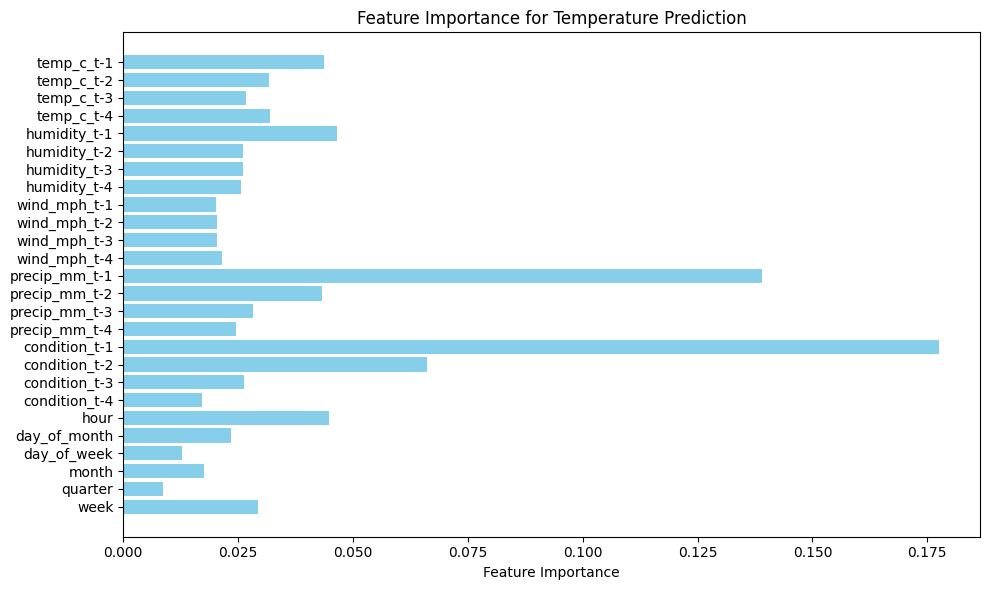

In [24]:
import matplotlib.pyplot as plt

# Dữ liệu feature importance
features = [
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "humidity_t-1", "humidity_t-2", "humidity_t-3", "humidity_t-4",
    "wind_mph_t-1", "wind_mph_t-2", "wind_mph_t-3", "wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2", "precip_mm_t-3", "precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",  
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week"
]

importances = [
    0.0437, 0.0318, 0.0267, 0.0319, 
    0.0465, 0.0260, 0.0261, 0.0256, 
    0.0201, 0.0205, 0.0205, 0.0216, 
    0.1391, 0.0433, 0.0283, 0.0245, 
    0.1776, 0.0661, 0.0263, 0.0172, 
    0.0447, 0.0235, 0.0129, 0.0175, 0.0087, 0.0294
]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Temperature Prediction")
plt.gca().invert_yaxis()  # Đảo ngược trục y để feature quan trọng nhất lên trên
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.ml.tuning import CrossValidatorModel
fv
# Đường dẫn tới thư mục lưu mô hình
model_path = "random_forest_model"

# Tải lại mô hình CrossValidatorModel
cvModel = CrossValidatorModel.load(model_path)

# Sau khi tải lại mô hình, bạn có thể truy cập mô hình Random Forest đã được huấn luyện từ CrossValidatorModel
rf_model = cvModel.bestModel

# Kiểm tra mô hình Random Forest
print(rf_model)


RandomForestClassificationModel: uid=RandomForestClassifier_2a9cc44074e7, numTrees=50, numClasses=21, numFeatures=26


In [ ]:
from pyspark.sql.functions import col, lag, hour, dayofmonth, dayofweek, month, quarter, weekofyear, to_date
from pyspark.sql.window import Window

# Bước 1: Tải dữ liệu mới từ Parquet
parquet_path = "/home/hoan123/project-master/delta_lake/delta_lake_table_3/"
newdf = spark.read.parquet(parquet_path)

# Bước 2: Lấy 4 bản ghi mới nhất dựa trên cột datetime
newdf_sorted = newdf.orderBy(col("datetime").desc()).limit(10)

# Bước 3: Tạo các cột lag cho dữ liệu giống như trong dữ liệu huấn luyện
window = Window.orderBy("datetime")

condition_to_index = {
    "Cloudy": 0,
    "Light rain": 1,
    "Patchy rain possible": 2,
    "Moderate or heavy rain shower": 3,
    "Patchy light rain": 4,
    "Clear": 5,
    "Partly cloudy": 6,
    "Sunny": 7,
    "Patchy light drizzle": 8,
    "Light drizzle": 9,
    "Patchy light rain with thunder": 10,
    "Mist": 11,
    "Moderate rain at times": 12,
    "Thundery outbreaks possible": 13,
    "Moderate or heavy rain with thunder": 14,
    "Overcast": 15,
    "Moderate rain": 16,
    "Light rain shower": 17,
    "Heavy rain": 18,
    "Heavy rain at times": 19,
    "Fog": 20
}

# Bước 2: Hàm chuyển đổi chuỗi sang chỉ số
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def map_condition(condition):
    return condition_to_index.get(condition, -1)  # Trả về -1 nếu không tìm thấy giá trị phù hợp

map_condition_udf = udf(map_condition, IntegerType())
newdf_sorted = newdf_sorted.withColumn("condition_index", map_condition_udf("condition"))

# Hiển thị kết quả
newdf_sorted.show()


+-------------------+-----+-------+--------+---------+------+--------+--------+---------+-------------+---------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|    condition|condition_index|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+-------------+---------------+
|2024-11-19 23:00:00|Hanoi|Vietnam| 21.0333|   105.85|  23.1|     3.8|    69.0|      0.0|Partly cloudy|              6|
|2024-11-19 22:00:00|Hanoi|Vietnam| 21.0333|   105.85|  23.8|     4.3|    66.0|      0.0|        Clear|              5|
|2024-11-19 21:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.5|     4.9|    62.0|      0.0|Partly cloudy|              6|
|2024-11-19 20:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     4.5|    59.0|      0.0|Partly cloudy|              6|
|2024-11-19 19:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.8|     1.8|    55.0|      0.0|       Cloudy|              0|
|2024-11-19 18:00:00|Hanoi|Vietnam| 21.0

In [ ]:

newdf_with_lags = (
    newdf_sorted
    .withColumn("temp_c_t-1", lag("temp_c", 1).over(window))
    .withColumn("temp_c_t-2", lag("temp_c", 2).over(window))
    .withColumn("temp_c_t-3", lag("temp_c", 3).over(window))
    .withColumn("temp_c_t-4", lag("temp_c", 4).over(window))
    .withColumn("humidity_t-1", lag("humidity", 1).over(window))
    .withColumn("humidity_t-2", lag("humidity", 2).over(window))
    .withColumn("humidity_t-3", lag("humidity", 3).over(window))
    .withColumn("humidity_t-4", lag("humidity", 4).over(window))
    .withColumn("wind_mph_t-1", lag("wind_mph", 1).over(window))
    .withColumn("wind_mph_t-2", lag("wind_mph", 2).over(window))
    .withColumn("wind_mph_t-3", lag("wind_mph", 3).over(window))
    .withColumn("wind_mph_t-4", lag("wind_mph", 4).over(window))
    .withColumn("precip_mm_t-1", lag("precip_mm", 1).over(window))
    .withColumn("precip_mm_t-2", lag("precip_mm", 2).over(window))
    .withColumn("precip_mm_t-3", lag("precip_mm", 3).over(window))
    .withColumn("precip_mm_t-4", lag("precip_mm", 4).over(window))
    .withColumn("condition_t-1", lag("condition_index", 1).over(window))
    .withColumn("condition_t-2", lag("condition_index", 2).over(window))
    .withColumn("condition_t-3", lag("condition_index", 3).over(window))
    .withColumn("condition_t-4", lag("condition_index", 4).over(window))
    .withColumn("hour", hour("datetime"))
    .withColumn("day_of_month", dayofmonth("datetime"))
    .withColumn("day_of_week", dayofweek("datetime"))
    .withColumn("month", month("datetime"))
    .withColumn("quarter", quarter("datetime"))
    .withColumn("week", weekofyear("datetime"))
)

# Bước 4: Chọn các cột cần thiết và chuyển đổi tên cột như dữ liệu huấn luyện
newdf_final = newdf_with_lags.select(
    "datetime", 
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "humidity_t-1", "humidity_t-2", "humidity_t-3", "humidity_t-4",
    "wind_mph_t-1", "wind_mph_t-2","wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",  
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week",
    "condition_index"  # Nhiệt độ hiện tại làm nhãn
).withColumnRenamed("condition_index", "label")

# Bước 5: Bỏ các hàng không đủ dữ liệu (nếu có)
newdf_final = newdf_final.na.drop()

# Bước 6: Chuyển dữ liệu thành feature vector
feature_cols = [
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "humidity_t-1", "humidity_t-2",  "humidity_t-3", "humidity_t-4",
    "wind_mph_t-1", "wind_mph_t-2", "wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
newdf_final = assembler.transform(newdf_final).select("features", "label", "datetime")

# Kết quả: DataFrame đã chuẩn bị để dự đoán
newdf_final.show()



24/12/10 16:19:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 1

+--------------------+-----+-------------------+
|            features|label|           datetime|
+--------------------+-----+-------------------+
|[27.4,28.7,28.8,2...|    5|2024-11-19 18:00:00|
|[26.4,27.4,28.7,2...|    0|2024-11-19 19:00:00|
|[25.8,26.4,27.4,2...|    6|2024-11-19 20:00:00|
|[25.0,25.8,26.4,2...|    6|2024-11-19 21:00:00|
|[24.5,25.0,25.8,2...|    5|2024-11-19 22:00:00|
|[23.8,24.5,25.0,2...|    6|2024-11-19 23:00:00|
+--------------------+-----+-------------------+



In [ ]:
# Giả sử bạn đã huấn luyện mô hình RandomForest
# Dự đoán trên dữ liệu đã chuẩn bị
predictions = rf_model.transform(newdf_final)

# Lấy các dự đoán cho 4 bản ghi cuối
predictions.show()

# Nếu bạn muốn chỉ lấy các dự đoán:
predictions.select("datetime", "features", "label", "prediction").show()


24/12/10 16:19:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 1

+--------------------+-----+-------------------+--------------------+--------------------+----------+
|            features|label|           datetime|       rawPrediction|         probability|prediction|
+--------------------+-----+-------------------+--------------------+--------------------+----------+
|[27.4,28.7,28.8,2...|    5|2024-11-19 18:00:00|[0.26354412930457...|[0.00527088258609...|       7.0|
|[26.4,27.4,28.7,2...|    0|2024-11-19 19:00:00|[0.15047413417776...|[0.00300948268355...|       5.0|
|[25.8,26.4,27.4,2...|    6|2024-11-19 20:00:00|[8.37618595841209...|[0.16752371916824...|       5.0|
|[25.0,25.8,26.4,2...|    6|2024-11-19 21:00:00|[2.85981272330931...|[0.05719625446618...|       6.0|
|[24.5,25.0,25.8,2...|    5|2024-11-19 22:00:00|[2.57874450283250...|[0.05157489005665...|       6.0|
|[23.8,24.5,25.0,2...|    6|2024-11-19 23:00:00|[1.95715963015061...|[0.03914319260301...|       5.0|
+--------------------+-----+-------------------+--------------------+-------------

24/12/10 16:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 1

+-------------------+--------------------+-----+----------+
|           datetime|            features|label|prediction|
+-------------------+--------------------+-----+----------+
|2024-11-19 18:00:00|[27.4,28.7,28.8,2...|    5|       7.0|
|2024-11-19 19:00:00|[26.4,27.4,28.7,2...|    0|       5.0|
|2024-11-19 20:00:00|[25.8,26.4,27.4,2...|    6|       5.0|
|2024-11-19 21:00:00|[25.0,25.8,26.4,2...|    6|       6.0|
|2024-11-19 22:00:00|[24.5,25.0,25.8,2...|    5|       6.0|
|2024-11-19 23:00:00|[23.8,24.5,25.0,2...|    6|       5.0|
+-------------------+--------------------+-----+----------+



24/12/10 16:19:55 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


In [ ]:
# Dự đoán bước 1
pred_1 = rf_model.transform(newdf_final)
df_pred_1 = pred_1.withColumn("predicted_label_t+1", col("prediction"))

# Cập nhật dữ liệu cho bước 2 (dùng pred_1 làm đầu vào cho bước tiếp theo)
df_pred_2 = (
    df_pred_1
    .withColumn("temp_c_t-1", col("temp_c_t-1").alias("temp_c_t-2"))
    .withColumn("temp_c_t-2", col("temp_c_t-2").alias("temp_c_t-3"))
    .withColumn("temp_c_t-3", col("temp_c_t-3").alias("temp_c_t-4"))
    .withColumn("temp_c_t-4", col("predicted_label_t+1"))  # Sử dụng dự đoán làm giá trị mới cho t-4
    .withColumn("condition_t-1", col("condition_t-1").alias("condition_t-2"))
    .withColumn("condition_t-2", col("condition_t-2").alias("condition_t-3"))
    .withColumn("condition_t-3", col("condition_t-3").alias("condition_t-4"))
    .withColumn("condition_t-4", col("predicted_label_t+1"))  # Cập nhật giá trị của condition
)

# Dự đoán bước 2
pred_2 = rf_model.transform(df_pred_2)
df_pred_2 = pred_2.withColumn("predicted_label_t+2", col("prediction"))

# Cập nhật dữ liệu cho bước 3
df_pred_3 = (
    df_pred_2
    .withColumn("temp_c_t-1", col("temp_c_t-1").alias("temp_c_t-2"))
    .withColumn("temp_c_t-2", col("temp_c_t-2").alias("temp_c_t-3"))
    .withColumn("temp_c_t-3", col("temp_c_t-3").alias("temp_c_t-4"))
    .withColumn("temp_c_t-4", col("predicted_label_t+2"))  # Sử dụng dự đoán làm giá trị mới cho t-4
    .withColumn("condition_t-1", col("condition_t-1").alias("condition_t-2"))
    .withColumn("condition_t-2", col("condition_t-2").alias("condition_t-3"))
    .withColumn("condition_t-3", col("condition_t-3").alias("condition_t-4"))
    .withColumn("condition_t-4", col("predicted_label_t+2"))  # Cập nhật giá trị của condition
)

# Dự đoán bước 3
pred_3 = rf_model.transform(df_pred_3)

# Hiển thị kết quả
pred_3.select("datetime", "features", "label", "prediction", "predicted_label_t+1", "predicted_label_t+2", "prediction").show()


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `temp_c_t-1` cannot be resolved. Did you mean one of the following? [`features`, `prediction`, `datetime`, `label`, `probability`].;
'Project [features#1754, label#1686, datetime#915, rawPrediction#1889, probability#1897, prediction#1909, predicted_label_t+1#1925, 'temp_c_t-1 AS temp_c_t-1#1934]
+- Project [features#1754, label#1686, datetime#915, rawPrediction#1889, probability#1897, prediction#1909, prediction#1909 AS predicted_label_t+1#1925]
   +- Project [features#1754, label#1686, datetime#915, rawPrediction#1889, probability#1897, UDF(rawPrediction#1889) AS prediction#1909]
      +- Project [features#1754, label#1686, datetime#915, rawPrediction#1889, UDF(rawPrediction#1889) AS probability#1897]
         +- Project [features#1754, label#1686, datetime#915, UDF(features#1754) AS rawPrediction#1889]
            +- Project [features#1754, label#1686, datetime#915]
               +- Project [datetime#915, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, precip_mm_t-2#1242, precip_mm_t-3#1268, precip_mm_t-4#1295, condition_t-1#1323, condition_t-2#1352, condition_t-3#1382, condition_t-4#1413, hour#1445, day_of_month#1478, day_of_week#1512, ... 5 more fields]
                  +- Filter atleastnnonnulls(28, datetime#915, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, precip_mm_t-2#1242, precip_mm_t-3#1268, precip_mm_t-4#1295, condition_t-1#1323, condition_t-2#1352, condition_t-3#1382, condition_t-4#1413, hour#1445, day_of_month#1478, ... 5 more fields)
                     +- Project [datetime#915, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, precip_mm_t-2#1242, precip_mm_t-3#1268, precip_mm_t-4#1295, condition_t-1#1323, condition_t-2#1352, condition_t-3#1382, condition_t-4#1413, hour#1445, day_of_month#1478, day_of_week#1512, ... 4 more fields]
                        +- Project [datetime#915, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, precip_mm_t-2#1242, precip_mm_t-3#1268, precip_mm_t-4#1295, condition_t-1#1323, condition_t-2#1352, condition_t-3#1382, condition_t-4#1413, hour#1445, day_of_month#1478, day_of_week#1512, ... 4 more fields]
                           +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 13 more fields]
                              +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 12 more fields]
                                 +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 11 more fields]
                                    +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 10 more fields]
                                       +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 9 more fields]
                                          +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 8 more fields]
                                             +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 7 more fields]
                                                +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 8 more fields]
                                                   +- Window [lag(condition_index#937, -4, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -4, -4)) AS condition_t-4#1413], [datetime#915 ASC NULLS FIRST]
                                                      +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 6 more fields]
                                                         +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 6 more fields]
                                                            +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 7 more fields]
                                                               +- Window [lag(condition_index#937, -3, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, -3)) AS condition_t-3#1382], [datetime#915 ASC NULLS FIRST]
                                                                  +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 5 more fields]
                                                                     +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 5 more fields]
                                                                        +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 6 more fields]
                                                                           +- Window [lag(condition_index#937, -2, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -2, -2)) AS condition_t-2#1352], [datetime#915 ASC NULLS FIRST]
                                                                              +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 4 more fields]
                                                                                 +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 4 more fields]
                                                                                    +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 5 more fields]
                                                                                       +- Window [lag(condition_index#937, -1, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS condition_t-1#1323], [datetime#915 ASC NULLS FIRST]
                                                                                          +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 3 more fields]
                                                                                             +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 3 more fields]
                                                                                                +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 4 more fields]
                                                                                                   +- Window [lag(precip_mm#923, -4, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -4, -4)) AS precip_mm_t-4#1295], [datetime#915 ASC NULLS FIRST]
                                                                                                      +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 2 more fields]
                                                                                                         +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 2 more fields]
                                                                                                            +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 3 more fields]
                                                                                                               +- Window [lag(precip_mm#923, -3, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, -3)) AS precip_mm_t-3#1268], [datetime#915 ASC NULLS FIRST]
                                                                                                                  +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, precip_mm_t-2#1242]
                                                                                                                     +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, precip_mm_t-2#1242]
                                                                                                                        +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, ... 2 more fields]
                                                                                                                           +- Window [lag(precip_mm#923, -2, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -2, -2)) AS precip_mm_t-2#1242], [datetime#915 ASC NULLS FIRST]
                                                                                                                              +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217]
                                                                                                                                 +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217]
                                                                                                                                    +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, precip_mm_t-1#1217, precip_mm_t-1#1217]
                                                                                                                                       +- Window [lag(precip_mm#923, -1, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS precip_mm_t-1#1217], [datetime#915 ASC NULLS FIRST]
                                                                                                                                          +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193]
                                                                                                                                             +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193]
                                                                                                                                                +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-4#1193, wind_mph_t-4#1193]
                                                                                                                                                   +- Window [lag(wind_mph#921, -4, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -4, -4)) AS wind_mph_t-4#1193], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                      +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170]
                                                                                                                                                         +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170]
                                                                                                                                                            +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-3#1170, wind_mph_t-3#1170]
                                                                                                                                                               +- Window [lag(wind_mph#921, -3, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, -3)) AS wind_mph_t-3#1170], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                  +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148]
                                                                                                                                                                     +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148]
                                                                                                                                                                        +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-2#1148, wind_mph_t-2#1148]
                                                                                                                                                                           +- Window [lag(wind_mph#921, -2, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -2, -2)) AS wind_mph_t-2#1148], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                              +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127]
                                                                                                                                                                                 +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127]
                                                                                                                                                                                    +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, wind_mph_t-1#1127, wind_mph_t-1#1127]
                                                                                                                                                                                       +- Window [lag(wind_mph#921, -1, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS wind_mph_t-1#1127], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                                          +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107]
                                                                                                                                                                                             +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107]
                                                                                                                                                                                                +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-4#1107, humidity_t-4#1107]
                                                                                                                                                                                                   +- Window [lag(humidity#922, -4, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -4, -4)) AS humidity_t-4#1107], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                                                      +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088]
                                                                                                                                                                                                         +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088]
                                                                                                                                                                                                            +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-3#1088, humidity_t-3#1088]
                                                                                                                                                                                                               +- Window [lag(humidity#922, -3, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, -3)) AS humidity_t-3#1088], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                                                                  +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070]
                                                                                                                                                                                                                     +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070]
                                                                                                                                                                                                                        +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-2#1070, humidity_t-2#1070]
                                                                                                                                                                                                                           +- Window [lag(humidity#922, -2, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -2, -2)) AS humidity_t-2#1070], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                                                                              +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053]
                                                                                                                                                                                                                                 +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053]
                                                                                                                                                                                                                                    +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, humidity_t-1#1053, humidity_t-1#1053]
                                                                                                                                                                                                                                       +- Window [lag(humidity#922, -1, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS humidity_t-1#1053], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                                                                                          +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037]
                                                                                                                                                                                                                                             +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037]
                                                                                                                                                                                                                                                +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-4#1037, temp_c_t-4#1037]
                                                                                                                                                                                                                                                   +- Window [lag(temp_c#920, -4, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -4, -4)) AS temp_c_t-4#1037], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                                                                                                      +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022]
                                                                                                                                                                                                                                                         +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022]
                                                                                                                                                                                                                                                            +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-3#1022, temp_c_t-3#1022]
                                                                                                                                                                                                                                                               +- Window [lag(temp_c#920, -3, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, -3)) AS temp_c_t-3#1022], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                                                                                                                  +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008]
                                                                                                                                                                                                                                                                     +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008]
                                                                                                                                                                                                                                                                        +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-2#1008, temp_c_t-2#1008]
                                                                                                                                                                                                                                                                           +- Window [lag(temp_c#920, -2, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -2, -2)) AS temp_c_t-2#1008], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                                                                                                                              +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995]
                                                                                                                                                                                                                                                                                 +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995]
                                                                                                                                                                                                                                                                                    +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937, temp_c_t-1#995, temp_c_t-1#995]
                                                                                                                                                                                                                                                                                       +- Window [lag(temp_c#920, -1, null) windowspecdefinition(datetime#915 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS temp_c_t-1#995], [datetime#915 ASC NULLS FIRST]
                                                                                                                                                                                                                                                                                          +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, condition_index#937]
                                                                                                                                                                                                                                                                                             +- Project [datetime#915, name#916, country#917, latitude#918, longitude#919, temp_c#920, wind_mph#921, humidity#922, precip_mm#923, condition#924, map_condition(condition#924)#936 AS condition_index#937]
                                                                                                                                                                                                                                                                                                +- GlobalLimit 10
                                                                                                                                                                                                                                                                                                   +- LocalLimit 10
                                                                                                                                                                                                                                                                                                      +- Sort [datetime#915 DESC NULLS LAST], true
                                                                                                                                                                                                                                                                                                         +- Relation [datetime#915,name#916,country#917,latitude#918,longitude#919,temp_c#920,wind_mph#921,humidity#922,precip_mm#923,condition#924] parquet
